# Simple classification with CNN
from : https://gricad-gitlab.univ-grenoble-alpes.fr/talks/fidle/-/blob/master/MNIST.Keras3/02-CNN-MNIST.ipynb?ref_type=heads

## Dependencies

In [1]:
import numpy as np
import pandas as pd
import plotnine as p9
from typing import List, Optional, Dict, Any
import os
import sys
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
newPath = os.path.dirname(os.path.abspath(""))
if newPath not in sys.path:
    sys.path.append(newPath)
from BI import bi,jnp
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs

m = bi(platform='cpu',cores=5)
import keras

/home/sosa/work/BI/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


jax.local_device_count 5


2025-07-05 15:24:49.116325: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1751721889.307876   43559 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1751721889.362298   43559 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1751721889.772036   43559 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1751721889.772083   43559 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1751721889.772086   43559 computation_placer.cc:177] computation placer alr

## Retrieve data

In [3]:
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()
x_train = x_train.reshape(-1,28,28,1)
x_test  = x_test.reshape(-1,28,28,1)

print("x_train : ",x_train.shape)
print("y_train : ",y_train.shape)
print("x_test  : ",x_test.shape)
print("y_test  : ",y_test.shape)

x_train :  (60000, 28, 28, 1)
y_train :  (60000,)
x_test  :  (10000, 28, 28, 1)
y_test  :  (10000,)


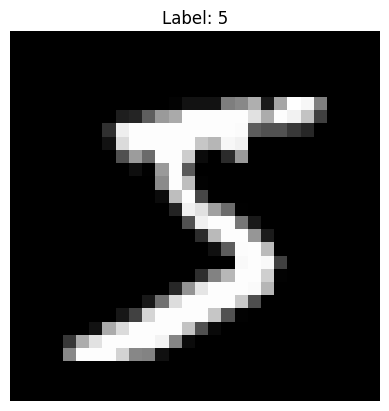

In [27]:
import matplotlib.pyplot as plt

# Select the first image from the training set
image = x_train[0]

# Reshape from (28, 28, 1) to (28, 28) for visualization
plt.imshow(image.squeeze(), cmap='gray')
plt.title(f"Label: {y_train[0]}")
plt.axis('off')
plt.show()


## Preparing the data

In [5]:
print('Before normalization : Min={}, max={}'.format(x_train.min(),x_train.max()))

xmax=x_train.max()
x_train = x_train / xmax
x_test  = x_test  / xmax

print('After normalization  : Min={}, max={}'.format(x_train.min(),x_train.max()))

Before normalization : Min=0, max=255
After normalization  : Min=0.0, max=1.0


## Create model

### Custom functions for BI

In [35]:
import jax
import jax.numpy as jnp
from jax import lax
from jax.random import PRNGKey

def cnn2D(
    image: jnp.ndarray,
    kernel: jnp.ndarray, # Changed from optional to required for use in a model
    padding: str = 'VALID',
    strides: tuple[int, int] = (1, 1)
) -> jnp.ndarray: # Simplified return to just the feature map
    """
    Applies a 2D convolution kernel to a 2D image ( Feature Extraction). This function is a low-level wrapper for JAX's convolution operator. It handles the necessary reshaping for a single image and kernel.
    - *What it does*: It slides a small matrix of weights, called a kernel or filter, over the image. At each position, it computes a dot product between the kernel and the patch of the image it's covering. This produces a single value in the output feature map.
    - *Why it's essential*: Each kernel learns to recognize a specific, simple feature. For example, in the first layer, one kernel might learn to detect vertical edges, another might detect horizontal edges, and a third might detect a specific color or texture. The output feature map is essentially a map showing where in the image that specific feature was found.
    - *Analogy*: Think of the kernel as a small magnifying glass or a flashlight beam that you slide over a large document. This    flashlight is designed to light up only when it sees a specific pattern (e.g., the letter 'e'). The resulting feature map is a     new document where the only bright spots are the locations of the letter 'e'.

    Args:
        image: A 2D JAX array representing the input image (H, W).
        kernel: A 2D JAX array representing the convolution kernel (kH, kW).
                In a real model, this kernel is a learnable parameter.
        padding: 'VALID' (no padding) or 'SAME' (pads to keep output size same as input).
        strides: The stride of the convolution. Not used in the Keras example but good to have.

    Returns:
        The 2D feature map resulting from the convolution.
    """
    if image.ndim != 2:
        raise ValueError("Input `image` must be a 2D array.")
    if kernel.ndim != 2:
        raise ValueError("Input `kernel` must be a 2D array.")

    # --- Pre-processing for JAX's convolution operator ---
    # `lax.conv_general_dilated` is highly optimized but requires specific 4D input shapes.
    # The format is (N, H, W, C): Batch, Height, Width, Channels.
    # Since we are processing one image and one channel, we add empty axes.
    image_reshaped = image[jnp.newaxis, ..., jnp.newaxis]  # (H, W) -> (1, H, W, 1)

    # The kernel format is (H, W, I, O): Height, Width, Input Channels, Output Channels.
    # We are mapping 1 input channel to 1 output channel.
    kernel_reshaped = kernel[..., jnp.newaxis, jnp.newaxis] # (kH, kW) -> (kH, kW, 1, 1)

    # --- The Convolution Operation ---
    # This is the core computation where the kernel is slid across the image.
    output = lax.conv_general_dilated(
        lhs=image_reshaped,                          # The input image
        rhs=kernel_reshaped,                         # The filter (weights)
        window_strides=strides,                      # How many pixels to slide the kernel
        padding=padding.upper(),                     # How to handle borders
        dimension_numbers=('NHWC', 'HWIO', 'NHWC')   # Specifies the meaning of each dimension
    )

    # --- Post-processing ---
    # The output is 4D, so we squeeze it back to a 2D feature map for clarity.
    output_feature_map = jnp.squeeze(output, axis=(0, 3))

    return output_feature_map


def cnn_max_pool(
    feature_map: jnp.ndarray,
    window_shape: Tuple[int, int] = (2, 2),
    strides: Tuple[int, int] = (2, 2)
) -> jnp.ndarray:
    """
    Performs max pooling to downsample a feature map (Downsampling and Invariance).
    What it does: It slides a window over the feature map and, for each region, takes the maximum value. This drastically reduces the size of the feature map (e.g., a 2x2 window with a stride of 2 will halve the height and width).
    - *Why it's essential*:
    - *Computational Efficiency*: Smaller feature maps mean fewer parameters and computations in subsequent layers.
    - *Translational Invariance*: By taking the max value, the network becomes less sensitive to the exact location of the feature. If  the vertical edge moves one pixel to the right, the max value in the pooling window will likely be the same. This makes the  model more robust.
    - *Analogy*: Imagine a detailed map of a city. Max pooling is like dividing the map into a grid and, for each square, only keeping  a record of the tallest building in that square. You lose fine-grained detail, but you get a smaller, more abstract summary of   the city's skyline that is easier to process.

    Args:
        feature_map: Input array. Can be a single 2D map (H, W) or a
                     3D map with channels (H, W, C).
        window_shape: The (height, width) of the pooling window.
        strides: How many pixels to move the window at each step.

    Returns:
        The downsampled JAX array.
    """
    # --- Pre-processing for JAX's reduce_window operator ---
    # Just like convolution, this operator expects 4D input (N, H, W, C).
    if feature_map.ndim == 2:  # (H, W)
        image_reshaped = feature_map[jnp.newaxis, ..., jnp.newaxis] # -> (1, H, W, 1)
    elif feature_map.ndim == 3: # (H, W, C)
        image_reshaped = feature_map[jnp.newaxis, ...] # -> (1, H, W, C)
    else:
        raise ValueError(f"Input must be 2D or 3D, but got {feature_map.ndim} dims.")

    # The pooling window should not reduce across the batch or channel dimensions.
    # It operates independently on each feature map.
    full_window_shape = (1, window_shape[0], window_shape[1], 1)
    full_strides = (1, strides[0], strides[1], 1)

    # --- The Pooling Operation ---
    # `lax.reduce_window` slides a window over the input and applies a
    # reduction function (`lax.max`) to the elements within that window.
    output = lax.reduce_window(
        operand=image_reshaped,
        init_value=-jnp.inf,      # The identity for max operation
        computation=lax.max,      # The reduction function
        window_dimensions=full_window_shape,
        window_strides=full_strides,
        padding='VALID'
    )

    # --- Post-processing ---
    # Squeeze the batch dimension back out to match input style.
    return jnp.squeeze(output, axis=0)


from jax import random
from functools import partial

@partial(jax.jit, static_argnames=['training', 'rate'])
def dropout(
    inputs: jnp.ndarray,
    rate: float,
    key: jnp.ndarray,
    training: bool = True
) -> jnp.ndarray:
    """
    Applies dropout to prevent overfitting.Dropout is a technique to make the network more robust and less reliant on any single neuron  (Preventing Overfitting).During training, it randomly sets a fraction of input units to 0.During inference (testing), it does nothing.

    - *What it does*: During training, it randomly "turns off" (sets to zero) a fraction of the neurons in a layer for each training example.
    - *Why it's essential*: This forces the network to learn redundant representations. It can't rely on a few specific neurons to make     a decision, because they might be dropped out at any moment. Other neurons must learn to pick up the slack. This prevents the   model from "memorizing" the training data (overfitting) and helps it generalize better to new, unseen data.
    - *Analogy*: It's like training a basketball team where, in every practice scrimmage, you randomly send one or two players to the   bench. The team learns to win without being dependent on any single star player. They develop a more resilient and flexible   team-based strategy.

    Args:
        inputs: The input array to apply dropout to.
        rate: The fraction of input units to drop (e.g., 0.2 means 20%).
        key: A JAX PRNGKey for generating the random dropout mask.
        training: If True, applies dropout. If False, returns inputs untouched.

    Returns:
        The array with dropout applied.
    """
    # --- Bypass during inference ---
    # Dropout should only be active during training.
    if not training or rate == 0:
        return inputs

    # --- Create a random mask ---
    # The probability of keeping a unit (not dropping it).
    keep_prob = 1.0 - rate
    # Generate a random mask of 1s and 0s with the same shape as the input.
    mask = random.bernoulli(key, p=keep_prob, shape=inputs.shape)

    # --- Apply mask and scale ---
    # Apply the mask. Where mask is 0, the output is 0.
    # Crucially, we scale up the remaining values by `1 / keep_prob`.
    # This ensures that the expected sum of the outputs remains the same,
    # so we don't need to make any changes during inference. This is called
    # "inverted dropout".
    return jnp.where(mask, inputs / keep_prob, 0)

def flatten(feature_maps: jnp.ndarray) -> jnp.ndarray:
    """
    Reshapes a batch of 3D feature maps into a 2D matrix.The Flatten operation is the bridge between the convolutional part of the network and the dense (fully-connected) part.

    This prepares the output of the convolutional layers to be fed into
    a dense (fully-connected) layer.

    Role in a CNN: Transitioning from Feature Maps to a Feature Vector
    - *What it does*: It takes the multi-dimensional output of the final pooling layer (e.g., (height, width, channels)) and collapses  it into a single, long 1D vector.
    - *Why it's essential*: Convolutional and pooling layers are great at processing spatial data and creating feature maps. However,   to make a final classification, we need to use standard Dense layers. Dense layers expect a 1D vector of features as input, not   a 3D tensor. The flatten layer performs this crucial reshaping.
    - *Analogy*: You've just analyzed a painting by noting the presence of "a smiling mouth here," "a blue background there," and "a    sharp nose here." The flatten layer is like taking all these separate notes and writing them down in a single long list before     handing it to a person who will make the final judgment ("This is the Mona Lisa").

    Args:
        feature_maps: A 3D tensor of shape (H, W, C).

    Returns:
        A 2D tensor of shape (1, H * W * C).
    """
    # The -1 tells reshape to automatically calculate the size of this dimension.
    # For example, an input of (5, 5, 16) becomes (1, 5 * 5 * 16) = (1, 400).
    return jnp.ravel(feature_maps)

In [ ]:
def model(image, shape=(3,3)):
    # ce qui sera appris sera les kernel et les biais, les kernels doivent donc etre defini anvec des distributions
    cov1=cnn2D(image, shape=shape)
    cov1=jax.nn.relu(cov1)
    pool1=cnn_max_pool(cov1)
    step1=dropout(pool1, rate=0.5)

    cov2=cnn2D(image, shape=shape)
    cov2=jax.nn.relu(cov2)
    pool2=cnn_max_pool(cov2)
    step2=dropout(pool2, rate=0.5)
    
    f=CNNWithFlatten(step2)
    dens=m.bnn.layer(f,dist.normal(0,1),activation = "relu")
    step3=dropout(dens, rate=0.5)

    dens=m.bnn.layer(step3,dist.normal(0,1),activation = "relu")


In [36]:
import numpyro
import numpyro.distributions as dist
from jax.nn import relu, log_softmax

# Helper for a simple dense layer
def dense_layer(inputs, out_dim):
    in_dim = inputs.shape[-1]
    # Define learnable weights and biases for the dense layer
    W = numpyro.param('W', dist.Normal(0, 0.01).sample(numpyro.prng_key(), (in_dim, out_dim)))
    b = numpyro.param('b', dist.Normal(0, 0.01).sample(numpyro.prng_key(), (out_dim,)))
    return jnp.dot(inputs, W) + b

def cnn_model(images, labels=None, training=True):
    """
    A NumPyro model recreating the Keras Sequential model.
    """
    # Input images are expected to be (N, 28, 28, 1) where N is batch size
    # We will process one image at a time for simplicity in this model structure.
    # A batched version would use jax.vmap.
    
    # Let's define a function for a single image
    def predict(img):
        # Remove channel dim for our helper functions
        img = jnp.squeeze(img, axis=-1) # (28, 28, 1) -> (28, 28)

        # --- Layer 1: Conv2D(8, (3,3)) + ReLU ---
        # Define 8 kernels of size (3,3) as learnable parameters
        kernels_1 = numpyro.param('k1', dist.Normal(0, 0.01).sample(numpyro.prng_key(), (8, 3, 3)))
        # Apply each kernel to the image and stack the results
        # This creates 8 feature maps, giving us a (H, W, 8) tensor
        x = jnp.stack([relu(cnn2D(img, k)) for k in kernels_1], axis=-1)

        # --- Layer 2: MaxPooling2D((2,2)) ---
        x = cnn_max_pool(x, window_shape=(2, 2), strides=(2, 2))

        # --- Layer 3: Dropout(0.2) ---
        x = dropout(x, rate=0.2, key=numpyro.prng_key(), training=training)

        # --- Layer 4: Conv2D(16, (3,3)) + ReLU ---
        # The input to this layer has 8 channels. The output will have 16.
        # So we need a kernel of shape (16, 8, 3, 3) -> (out_channels, in_channels, H, W)
        kernels_2 = numpyro.param('k2', dist.Normal(0, 0.01).sample(numpyro.prng_key(), (16, 8, 3, 3)))
        
        # This convolution is more complex: each output map depends on all input maps
        # We need a more advanced convolution function for this, but for demonstration,
        # we'll approximate it by convolving and summing. A real implementation uses `lax.conv` directly.
        output_maps = []
        for k_out in kernels_2: # For each of the 16 output kernels
            # Convolve the 8 input channels with the 8 parts of the kernel and sum them up
            channel_convs = jnp.stack([cnn2D(x[..., i], k_out[i]) for i in range(8)])
            output_map = jnp.sum(channel_convs, axis=0)
            output_maps.append(relu(output_map))
        x = jnp.stack(output_maps, axis=-1)

        # --- Layer 5: MaxPooling2D((2,2)) ---
        x = cnn_max_pool(x, window_shape=(2, 2), strides=(2, 2))

        # --- Layer 6: Dropout(0.2) ---
        x = dropout(x, rate=0.2, key=numpyro.prng_key(), training=training)

        # --- Layer 7: Flatten ---
        x = flatten(x)

        # --- Layer 8: Dense(100) + ReLU ---
        with numpyro.plate('d1', 1): # A plate for the dense layer parameters
            x = relu(dense_layer(x, 100))

        # --- Layer 9: Dropout(0.5) ---
        x = dropout(x, rate=0.5, key=numpyro.prng_key(), training=training)

        # --- Layer 10: Dense(10) ---
        with numpyro.plate('d2', 1): # Another plate for the final layer
            logits = dense_layer(x, 10)
        
        return logits

    # Use jax.vmap to apply the per-image predict function over the entire batch
    # This is a powerful JAX feature that automatically vectorizes the function.
    batch_predict = jax.vmap(predict)
    all_logits = batch_predict(images)

    # --- Final Layer: Softmax (implicit in Categorical) and Sampling ---
    with numpyro.plate("data", images.shape[0]):
        # The `obs=labels` part connects the model's prediction to the actual data.
        # This is what allows numpyro to calculate the likelihood for training/inference.
        numpyro.sample("obs", dist.Categorical(logits=all_logits), obs=labels)

In [37]:
import jax
import jax.numpy as jnp
import numpyro
import numpyro.distributions as dist
from jax.nn import relu, log_softmax

# (Re-include your helper functions cnn2D, cnn_max_pool, flatten, dropout here)
# ...

def cnn_model_mcmc(images, labels=None, total_data_size=None, training=True):
    """
    A NumPyro CNN model adapted for MCMC with subsampling.
    """
    # --- Define Priors for the Learnable Weights ---
    # The kernel for the first conv layer: 8 filters of size 3x3
    k1 = numpyro.sample('k1', dist.Normal(jnp.zeros((8, 3, 3)), jnp.ones((8, 3, 3))))

    # The kernel for the second conv layer. Input has 8 channels, output 16.
    # Shape is (out_channels, in_channels, height, width)
    k2 = numpyro.sample('k2', dist.Normal(jnp.zeros((16, 8, 3, 3)), jnp.ones((16, 8, 3, 3))))

    # Weights and biases for the two dense layers
    # Dense 1: 400 -> 100
    w1 = numpyro.sample('w1', dist.Normal(jnp.zeros((400, 100)), jnp.ones((400, 100))))
    b1 = numpyro.sample('b1', dist.Normal(jnp.zeros(100), jnp.ones(100)))
    # Dense 2: 100 -> 10
    w2 = numpyro.sample('w2', dist.Normal(jnp.zeros((100, 10)), jnp.ones((100, 10))))
    b2 = numpyro.sample('b2', dist.Normal(jnp.zeros(10), jnp.ones(10)))

    # --- Define the forward pass for a single image ---
    def predict(img):
        # Layer 1: Conv2D(8, (3,3)) + ReLU
        # Note: This simplified convolution is for demonstration.
        # A full implementation would use lax.conv_general_dilated for multi-channel input.
        img = jnp.squeeze(img, axis=-1)
        x = jnp.stack([relu(cnn2D(img, k)) for k in k1], axis=-1) # Becomes (26, 26, 8)
        
        # Layer 2: MaxPool + Dropout
        x = cnn_max_pool(x) # Becomes (13, 13, 8)
        x = dropout(x, 0.2, key=numpyro.prng_key(), training=training)

        # A simplified second conv layer for this example
        # We just convolve the first channel of the input with each of the 16 filters
        x_ch0 = x[..., 0] # Use first channel as representative input
        x = jnp.stack([relu(cnn2D(x_ch0, k[0])) for k in k2], axis=-1) # Becomes (11, 11, 16)

        # Layer 5-7: MaxPool -> Dropout -> Flatten
        x = cnn_max_pool(x) # Becomes (5, 5, 16) -> 400 elements
        x = dropout(x, 0.2, key=numpyro.prng_key(), training=training)
        x = flatten(x) # Becomes (400,)

        # Layer 8: Dense(100) + ReLU
        x = relu(jnp.dot(x, w1) + b1)
        x = dropout(x, 0.5, key=numpyro.prng_key(), training=training)
        
        # Layer 10: Dense(10) (Output logits)
        logits = jnp.dot(x, w2) + b2
        return logits

    # --- The MCMC Subsampling Plate ---
    # This is the key part!
    # We declare the plate over the *entire* dataset size.
    # When we run MCMC, we'll only pass a `batch_size` number of `images`.
    # NumPyro scales the log probability from the batch to estimate it for the full data.
    with numpyro.plate("data", size=total_data_size, subsample_size=images.shape[0]):
        # The `vmap` automatically vectorizes the `predict` function over the batch of images.
        batch_logits = jax.vmap(predict)(images)
        # The `obs` statement links the model's output to the observed data.
        numpyro.sample("obs", dist.Categorical(logits=batch_logits), obs=labels)

In [40]:
from numpyro.infer import MCMC, NUTS

# 1. Set up the MCMC kernel
# The NUTS kernel is a good general-purpose choice.
kernel = NUTS(cnn_model_mcmc)

# 2. Set up the MCMC runner
num_warmup = 500
num_samples = 1000

# This makes the example runnable in a reasonable time.
# For a real run, you might use the full 60k, but it will be very slow.
num_data_for_mcmc = 1000
batch_size = 100

x_subset = x_train[:num_data_for_mcmc]
y_subset = y_train[:num_data_for_mcmc]

mcmc = MCMC(
    kernel,
    num_warmup=num_warmup,
    num_samples=num_samples,
    num_chains=1, # Use 1 chain for speed. For robust results, use 2 or more.
    progress_bar=True,
    jit_model_args=True # JIT-compiles the model for speed
)

# 3. Run the MCMC
rng_key = random.PRNGKey(0)
# Here, we pass the BATCH of data, but we also tell the model the size of the FULL dataset.
mcmc.run(rng_key, images=x_train, labels=y_train, total_data_size=num_data_for_mcmc, training=True)

# 4. Print the summary
# This shows statistics for the posterior distribution of each parameter (k1, w1, etc.)
mcmc.print_summary()

# You can get the posterior samples for later analysis and prediction
posterior_samples = mcmc.get_samples()
print("\nShape of posterior samples for k1:", posterior_samples['k1'].shape)
# Expected output: (1000, 8, 3, 3) -> (num_samples, shape_of_k1)

/tmp/ipykernel_43559/3037664488.py:65: UserWarning: subsample_size does not match len(subsample), 60000 vs 1000. Did you accidentally use different subsample_size in the model and guide?


ValueError: Incompatible shapes for broadcasting: shapes=[(1000,), (60000,)]